In [1]:
import os
import re
import glob
import numpy  as np
import pandas as pd

from os.path import expandvars, join, basename

import matplotlib.pyplot as plt
%matplotlib widget

In [2]:
# def read_mctrue(filename):
#     tracks = wcr.read_table(filename, "/wcsimT/Tracks")

#     selcols = ("Start_x0", "Start_x1", "Start_x2", "Time", "Dir_x0", "Dir_x1", "Dir_x2", "P", "StopVol")
    
#     # read parent particles
#     df = tracks.loc[(tracks.Parenttype == 0) & (tracks.Flag == 0) & (tracks.Id == 1), selcols]

#     # compute direction angles
#     columns = ("x", "y", "z", "t", "theta", "phi", "p", "StopVol")
#     x = df["Dir_x0"].values
#     y = df["Dir_x1"].values
#     z = df["Dir_x2"].values
#     theta = np.arccos(z)
#     phi   = np.arctan2(y, x)
#     phi[(np.sign(phi)<0)] += 2.*np.pi

#     df1 = pd.DataFrame(dict(zip( columns
#                                , [*df.loc[:, selcols[:4]].values.T
#                                , theta, phi
#                                , df.loc[:, "P"].values, df.loc[:, "StopVol"].values])))
#     return df1

mass = {1:0.510998, 2:105.6583}

In [10]:
pid   = 2
indir = expandvars(f"$LUSTRE/Validation/{'e-' if pid==1 else ('mu-' if pid == 2 else 'pi+')}/fitqun/Ryo/")

fitqun = dict()
filenames = glob.glob(join(indir, "*.csv"))
for filename in filenames: # loop on momentum
    energy = float(re.findall(r'\d+(?:\.\d+)?', basename(filename))[0])
    df = pd.read_csv(filename)
    fitqun[energy] = df.loc[df.pid == pid]

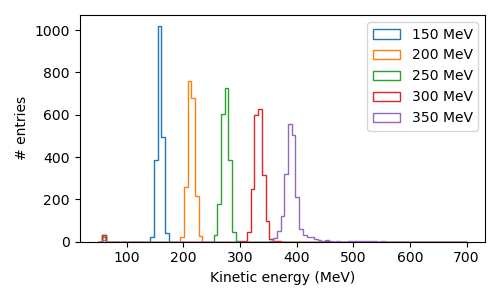

In [11]:
contained = False
ebins = np.linspace(50, 700, 100)

plt.figure(figsize=(5, 3))
for i, energy in enumerate(sorted(fitqun.keys())):

    df = fitqun[energy]
    # df = df[df.t<1000.]
    if contained:
        df = df.loc[df.pc == 0]
    K = ((df.p**2 + mass[pid]**2)**0.5 - mass[pid]).values
    err = abs(K - energy)/energy

    plt.hist(K, bins=ebins, label=f"{int(energy)} MeV", histtype="step")

plt.xlabel("Kinetic energy (MeV)")
plt.ylabel("# entries")
plt.legend()
plt.tight_layout()

In [5]:
pid   = 1
indir = expandvars(f"$LUSTRE/Validation/{'e-' if pid==1 else ('mu-' if pid == 2 else 'pi+')}/Ryo")

fitqun = dict()
filenames = glob.glob(join(indir, "*.csv"))
for filename in filenames: # loop on momentum
    energy = float(re.findall(r'\d+(?:\.\d+)?', basename(filename))[0])
    df = pd.read_csv(filename)
    fitqun[energy] = df.loc[(df.pid == pid)]

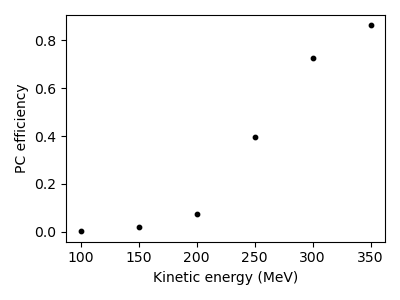

In [6]:
energies      = []
pc_efficiency = []

for i, energy in enumerate(sorted(fitqun.keys())):
    df = fitqun[energy]
    pc_efficiency.append(sum(df.pc == 1)/len(df))
    energies     .append(energy)
pc_efficiency = np.array(pc_efficiency)

plt.figure(figsize=[4, 3])
plt.scatter(energies, pc_efficiency, s=10, c="k")
plt.xlabel("Kinetic energy (MeV)")
plt.ylabel("PC efficiency")
plt.tight_layout()

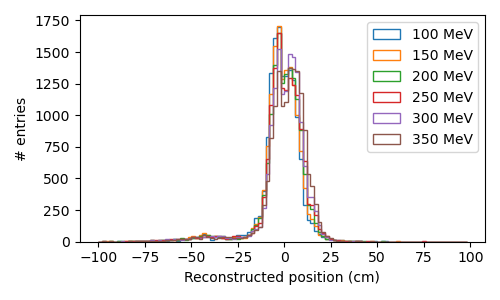

In [7]:
posbins = np.arange(-100, 100, 2)

plt.figure(figsize=(5, 3))
for i, energy in enumerate(sorted(fitqun.keys())):

    # if energy>=300: continue

    df = fitqun[energy]
    plt.hist(df.z, bins=posbins, label=f"{int(energy)} MeV", histtype="step")

# plt.axvline(0, label="Expected", color="k", linestyle="--")

plt.xlabel("Reconstructed position (cm)")
plt.ylabel("# entries")
plt.legend()
plt.tight_layout()

### PID

In [8]:
pid   = 1
indir = expandvars(f"$LUSTRE/Validation/{'e-' if pid==1 else ('mu-' if pid == 2 else 'pi+')}/Ryo")

def read_fitqun_data(indir):
    event_counter = 0
    fitqun = pd.DataFrame()
    filenames = glob.glob(join(indir, "*.csv"))
    for filename in filenames: # loop on momentum
        energy = float(re.findall(r'\d+(?:\.\d+)?', basename(filename))[0])
        df = pd.read_csv(filename)
        df = df[(df.pid == 1)|(df.pid == 2)]
        df.Event += event_counter
        fitqun = pd.concat([fitqun, df])
        event_counter += df.Event.nunique()
    fitqun.set_index("Event", inplace=True)
    return fitqun

fitqun_e  = read_fitqun_data(expandvars("$LUSTRE/Validation/e-/Ryo/"))
fitqun_mu = read_fitqun_data(expandvars("$LUSTRE/Validation/mu-/Ryo/"))

In [9]:
fitqun_mu = fitqun_mu[fitqun_mu.t<1000.]
fitqun_mu = fitqun_mu.loc[fitqun_mu.groupby(level=0).pid.sum() == 3]

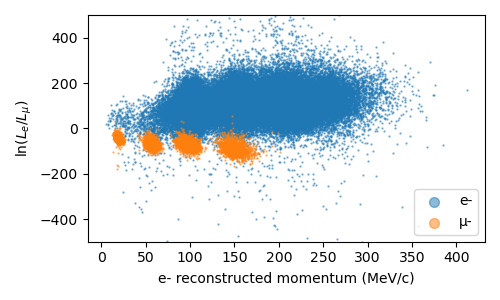

In [10]:
plt.figure(figsize=[5, 3])

for pid, fitqun in enumerate([fitqun_e, fitqun_mu], 1):
    fitqun = fitqun.loc[fitqun.groupby(level=0).p.max() <= 600]
    fitqun = fitqun.loc[fitqun.groupby(level=0).pc.sum()<= 0  ]
    
    ps      =  fitqun[fitqun.pid == 1].p
    lgLeLmu = -fitqun[fitqun.pid == 1].nll1R + fitqun[fitqun.pid == 2].nll1R

    plt.scatter(ps, lgLeLmu, s=0.5, label=f"{'e-' if pid==1 else ('μ-' if pid == 2 else 'pi+')}", alpha=0.5)

plt.ylim([-500, 500])
plt.xlabel("e- reconstructed momentum (MeV/c)")
plt.ylabel(r"$\ln (L_e / L_{\mu})$")
plt.legend(loc='lower right', markerscale=10)
plt.tight_layout()

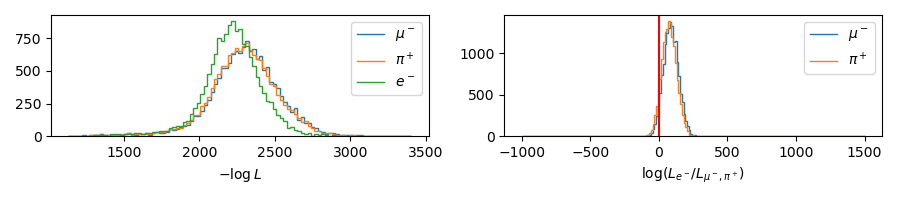

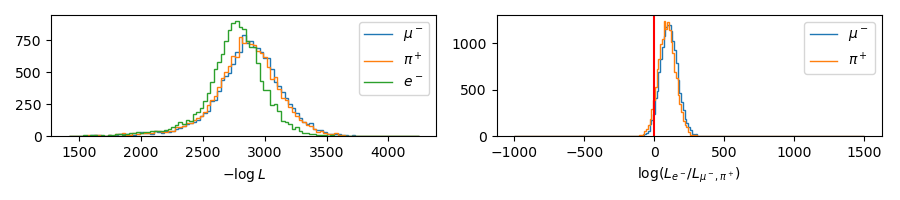

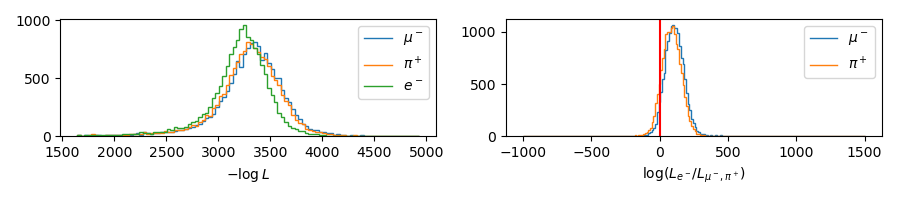

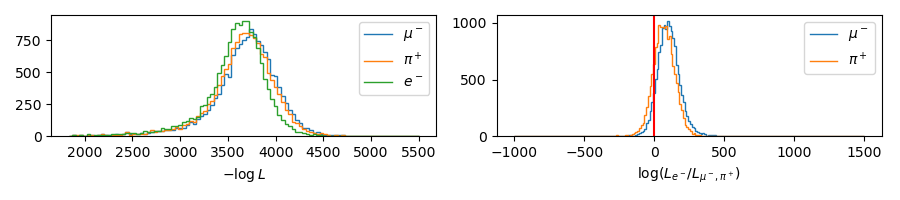

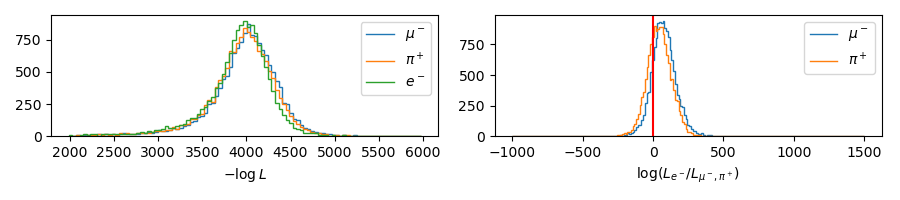

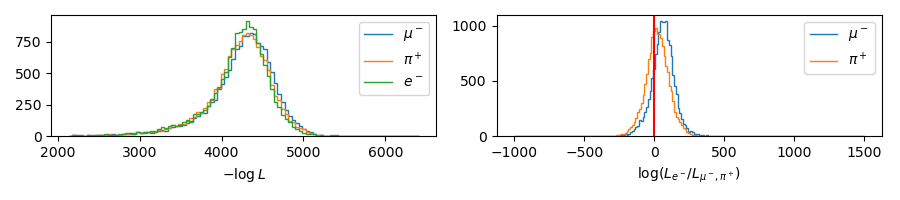

In [15]:
pids = [(r"$\mu^-$", 2), (r"$\pi^+$", 3), (r"$e^-$", 1)]

pid = 1
indir = expandvars(f"$LUSTRE/Validation/{'e-' if pid==1 else ('mu-' if pid == 2 else 'pi+')}/Ryo")

fitqun = dict()
filenames = glob.glob(join(indir, "*.csv"))
for filename in filenames: # loop on momentum
    energy = float(re.findall(r'\d+(?:\.\d+)?', basename(filename))[0])
    df = pd.read_csv(filename)
    fitqun[energy] = df


for momentum in sorted(fitqun.keys()):
    fits = fitqun[momentum]
    nll = fits.set_index("pid").nll1R

    plt.figure(figsize=[9, 2])

    # -logL bare plot
    plt.subplot(121)
    bins = np.linspace(nll.median()*0.5, nll.median()*1.5, 100)
    for particle, pid in pids:
        h, _ = np.histogram(nll.loc[pid], bins=bins)
        plt.stairs(h, bins, label=particle)
    plt.xlabel(r"$-\log L$")
    plt.legend()

    # quotient plot
    plt.subplot(122)
    bins = np.linspace(-1e3, 1.5e3, 200)
    for particle, pid in pids[:-1]:
        h, bins = np.histogram(-(nll.loc[1].values - nll.loc[pid].values), bins=bins)
        plt.stairs(h, bins, label=particle)
    plt.axvline(0, color="r")
    plt.xlabel(r"$\log ( L_{e^-}/L_{\mu^-,\pi^+})$")
    plt.legend()

    plt.tight_layout()

In [57]:
# # select only events with all reconstructed particles are PC
# sel = fits.groupby("Event").pc.sum() == 0

# print("Momentum:")
# print("---------")
# print("FC efficiency ", sel.sum()/len(sel))
# print()

# fits = fits.set_index("Event").loc[sel]
# nll = fits.set_index("pid").nll1R

In [58]:
# # select only events with all reconstructed particles are PC
# sel = fits.groupby("Event").pc.sum() == 0

# print("Momentum:")
# print("---------")
# print("FC efficiency ", sel.sum()/len(sel))
# print()

# fits = fits.set_index("Event").loc[sel]
# nll = fits.set_index("pid").nll1R

### Reconstruction

FC efficiency  0.9988


NameError: name 'AutoMinorLocator' is not defined

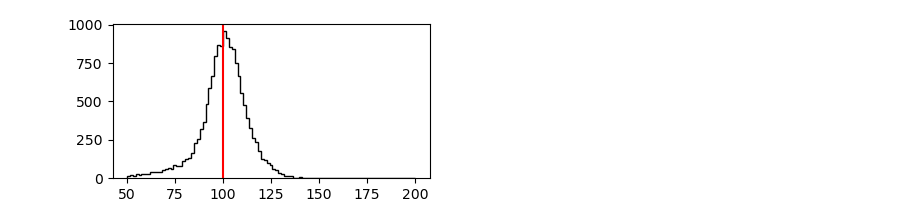

In [16]:
pid = 1

for momentum in sorted(fitqun.keys()):
    fits = fitqun[momentum]

    print("FC efficiency ", (fits[fits.pid == pid].pc == 0).sum()/len(fits[fits.pid == pid]))

    plt.figure(figsize=[9, 2])
    plt.subplot(121)

    p = fits[(fits.pid == pid)&(fits.pc == 0)].p.values
    p = fits[(fits.pid == pid)].p.values
    plt.hist(p, bins=np.linspace(momentum*0.5, momentum*2., 100), histtype="step", color="k")
    plt.axvline(momentum, color="r")
    plt.gca().xaxis.set_minor_locator(AutoMinorLocator(5))
    plt.gca().tick_params(which='both', direction="in", length=5)
    plt.xlabel("p (MeV/c)")

    plt.subplot(122)
    pull = (fits[(fits.pid == pid)&(fits.pc == 0)].p.values - momentum)/momentum
    pull = (fits[(fits.pid == pid)].p.values - momentum)/momentum
    plt.hist(pull, bins=np.linspace(-1, 1, 100), histtype="step", color="k")
    plt.axvline(0, color="r")
    plt.gca().xaxis.set_minor_locator(AutoMinorLocator(5))
    plt.gca().tick_params(which='both', direction="in", length=5)
    plt.xlabel(r"$(p - p_{true})/p_{true}$")

    plt.tight_layout()

FC efficiency  0.9988


NameError: name 'AutoMinorLocator' is not defined

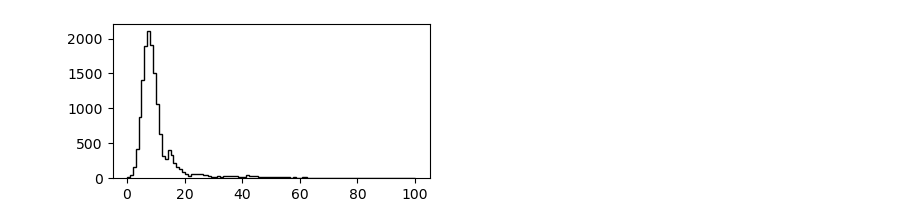

In [17]:
pid = 1

for momentum in sorted(fitqun.keys()):
    fits = fitqun[momentum]

    print("FC efficiency ", (fits[fits.pid == pid].pc == 0).sum()/len(fits[fits.pid == pid]))

    plt.figure(figsize=[9, 2])
    plt.subplot(121)

    df = fits[(fits.pid == pid)&(fits.pc == 0)]
    df = fits[(fits.pid == pid)]
    d = (df.x**2 + df.z**2)**0.5
    plt.hist(d, bins=np.linspace(0, 100, 100), histtype="step", color="k")
    plt.gca().xaxis.set_minor_locator(AutoMinorLocator(5))
    plt.gca().tick_params(which='both', direction="in", length=5)
    plt.xlabel("distance (cm)")

    plt.tight_layout()